# Notebook to compare modelled (MERRA-2, SNOWPACK, RACMO2, and MAR) vs observed SMB from IceBridge snow accumulation radar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr
from pyproj import Geod

## Load observed SMB from Dattler et. al., 2019

In [2]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

# Transform obs lat/lon into epsg 3031

In [3]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

## Load SNOWPACK SMB

In [4]:
# SNOWPACK SMB
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)

# SNOWPACK topography 
dem = np.loadtxt("../input/surface-grids/dem.asc", skiprows=6)
dem = xr.DataArray(dem, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

## Determine SNOWPACK domain corners

In [5]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

## Plot observed SMB (blue circles) and model domain (red rectangle)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


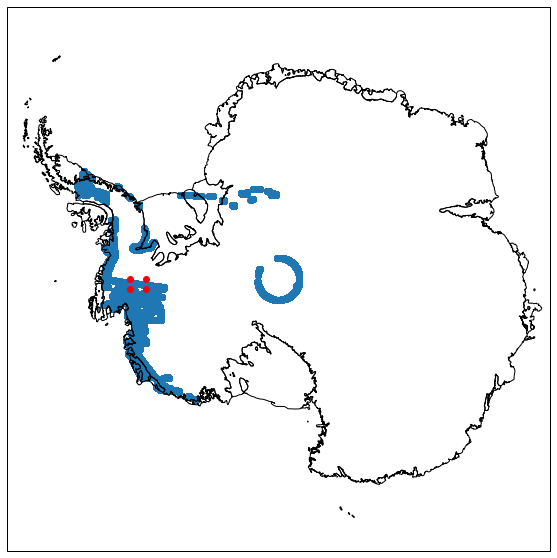

In [6]:
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot obs locations
plt.scatter(obs_X, obs_Y)

# Plot model domain
plt.scatter(domain_left, domain_bottom, c='r')
plt.scatter(domain_left, domain_top, c='r')
plt.scatter(domain_right, domain_bottom, c='r')
plt.scatter(domain_right, domain_top, c='r')

## Determine indices of observations which are in SNOWPACK model domain

In [7]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    obs_accum_filter = obs_accum[filter_func(obsX, obsY)]
    obsX_filter = obsX[filter_func(obsX, obsY)]
    obsY_filter = obsY[filter_func(obsX, obsY)]
    
    return obsX_filter, obsY_filter, obs_accum_filter

## Retrieve SNOWPACK and observed SMB 

In [8]:
# Retrieve observations
obs_X, obs_Y, obs_accumulation = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top)

In [9]:
# Retrieve SNOWPACK at observations
SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
SNOWPACK_SMB = SNOWPACK_SMB.sel(northing=obs_Y, easting=obs_X, method='nearest')
SNOWPACK_SMB = SNOWPACK_SMB.values.diagonal()
SNOWPACK_SMB = SNOWPACK_SMB

# Retrieve elevation at observations
dem = dem.sel(northing=obs_Y, easting=obs_X, method='nearest')
dem = dem.values.diagonal()

## Scatter plot of SNOWPACK and observed SMB

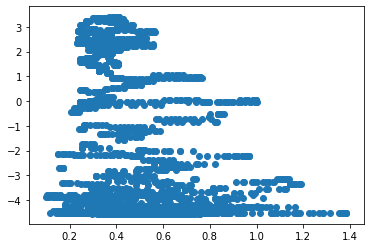

In [10]:
plt.scatter(obs_accumulation, SNOWPACK_SMB)

## Horizontal ransect of SNOWPACK vs obserced SMB

Text(0, 0.5, 'Elevation [m]')

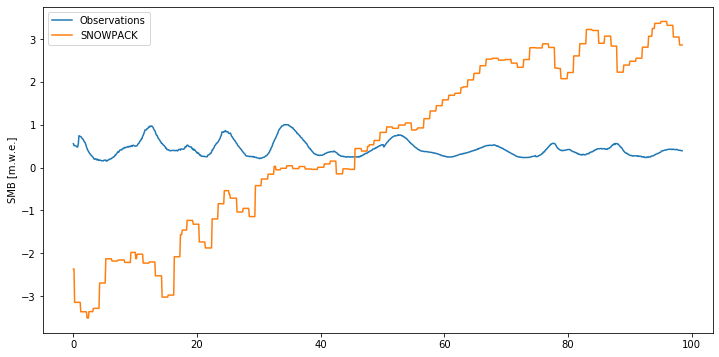

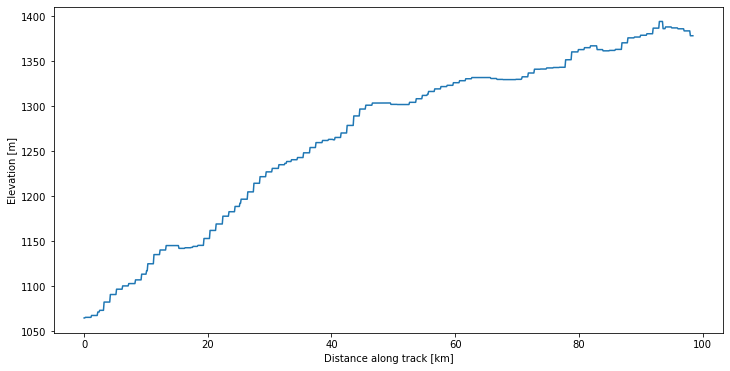

In [11]:
# Indices to plot
ind0 = 1000
indf = 2000
indices = np.arange(ind0, indf)

# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

# Plot 
plt.figure(figsize=(12,6))
plt.plot(dat, obs_accumulation[indices], label='Observations')
plt.plot(dat, SNOWPACK_SMB[indices], label="SNOWPACK")
plt.legend()
plt.ylabel("SMB [m.w.e.]")

plt.figure(figsize=(12,6))
plt.plot(dat, dem[indices], label="Elevation")
plt.xlabel("Distance along track [km]")
plt.ylabel("Elevation [m]")


## Normalized observations and models

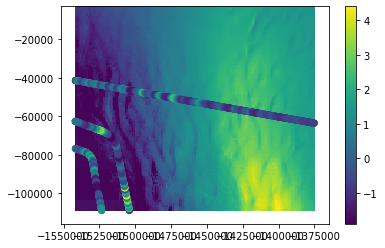

In [12]:
# Load in 1980 SNOWPACK SWE
x_snowpack = ds['easting']
y_snowpack = ds['northing']
swe = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)

# Normalize data
swe_norm = (swe - np.mean(swe)) / np.std(swe)
obs_swe_norm = (obs_accumulation - np.nanmean(obs_accumulation)) / np.nanstd(obs_accumulation)

plt.pcolormesh(x_snowpack, y_snowpack, swe_norm)
plt.scatter(obs_X, obs_Y, c=obs_swe_norm)
plt.colorbar()


# SNOWPACK Topography (CryoSat-2)

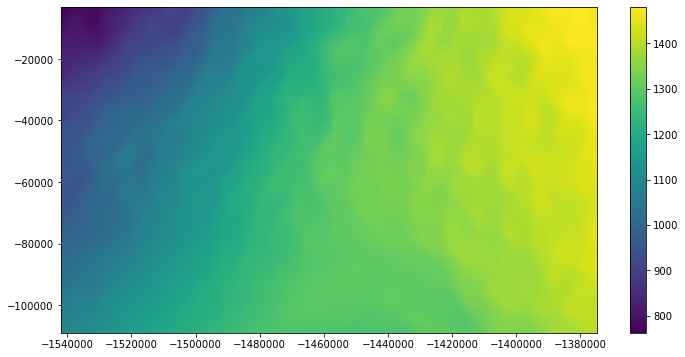

In [13]:
# SNOWPACK topography 
dem_viz = np.loadtxt("../input/surface-grids/dem.asc", skiprows=6)
dem_viz = xr.DataArray(dem_viz, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

# Plot DEM and observations
plt.figure(figsize=(12,6))
plt.pcolormesh(x_snowpack, y_snowpack, dem_viz)
plt.colorbar()
# plt.scatter(obs_X[indices], obs_Y[indices], c='k')

